In [1]:
import sys, os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(os.path.join('..', '..'))
from scripts.ipa_transcription.wav2vec2_streaming import stream_cnn_chunked_transformer, stream_naive_chunked, stream_naive, transcribe
from scripts.ipa_transcription.wav2vec2 import load_model
from scripts.eval.streaming import run_array_source
from scripts.eval.metrics import fer, per

from scripts.data_loaders.TIMIT import TIMITDataset

In [2]:
model, processor = load_model(model_id="KoelLabs/xlsr-english-01")

### Evaluating Streaming on TIMIT
we will use TIMIT to test the latency and accuracy of streaming for an optimized and traditional streaming method of the wav2vec2 architecture with KoelLabs' model

In [3]:
dataset = TIMITDataset(split="test")

In [5]:
methods = [stream_cnn_chunked_transformer, stream_naive_chunked, stream_naive]

In [6]:
# create results file with columns
RESULT_CSV = "../../.data/timit_streaming_results.csv"
columns = [
    "groundtruth", 
    "non_streaming_transcript", 
    "non_streaming_fer_scores", 
    "non_streaming_per_scores",
    "non_streaming_time",
    "stream_naive_transcript",
    "stream_naive_fer_scores",
    "stream_naive_per_scores",
    "stream_naive_stream_duration",
    "stream_naive_computation_time",
    "stream_naive_warmup_latency",
    "stream_naive_average_first_guess_latency",
    "stream_naive_average_final_guess_latency",
    "stream_naive_overall_time",
    "stream_naive_chunked_transcript",
    "stream_naive_chunked_fer_scores",
    "stream_naive_chunked_per_scores",
    "stream_naive_chunked_stream_duration",
    "stream_naive_chunked_computation_time",
    "stream_naive_chunked_warmup_latency",
    "stream_naive_chunked_average_first_guess_latency",
    "stream_naive_chunked_average_final_guess_latency",
    "stream_naive_chunked_overall_time",
    "stream_cnn_chunked_transformer_transcript",
    "stream_cnn_chunked_transformer_fer_scores",
    "stream_cnn_chunked_transformer_per_scores",
    "stream_cnn_chunked_transformer_stream_duration",
    "stream_cnn_chunked_transformer_time",
    "stream_cnn_chunked_transformer_warmup_latency",
    "stream_cnn_chunked_transformer_average_first_guess_latency",
    "stream_cnn_chunked_transformer_average_final_guess_latency",
    "stream_cnn_chunked_transformer_overall_time",
]
if os.path.exists(RESULT_CSV):
    results = pd.read_csv(RESULT_CSV)
    for col in columns:
        if col not in results.columns:
            results[col] = np.nan
    results = results[columns]
else:
    results = pd.DataFrame(columns=columns)


In [ ]:

for idx, sample in enumerate(dataset): 
    ground_truth, audio = sample
    start = time.perf_counter()
    non_streaming_transcript = "".join(p for (p, _, _) in transcribe(audio, processor, model))
    non_streaming_time = time.perf_counter() - start
    non_streaming_fer_scores = fer(ground_truth, non_streaming_transcript)
    non_streaming_per_scores = per(ground_truth, non_streaming_transcript)
    row_data = {
        "groundtruth": ground_truth,
        "non_streaming_transcript": non_streaming_transcript,
        "non_streaming_fer_scores": non_streaming_fer_scores,
        "non_streaming_per_scores": non_streaming_per_scores,
        "non_streaming_time": non_streaming_time,
    }
    # --- remaining streaming methods ---
    for method in methods: 
        final_transcript = ""
        ws = run_array_source(audio, slow_down_to_realtime=True)
        start = time.perf_counter()
        for update in method(ws, processor=processor, model=model):
            final_transcript = update
            print("\r" + update, end="", flush=True)
        overall_time = time.perf_counter() - start
        (
            audio_duration,
            stream_duration,
            computation_time,
            warmup_latency,
            average_first_guess_latency,
            average_final_guess_latency,
        ) = ws.evaluate()
        del ws
        fer_score = fer(non_streaming_transcript, final_transcript)
        per_score = per(non_streaming_transcript, final_transcript)

        # write to columns using {method}_ prefix
        method_name = method.__name__ if hasattr(method, '__name__') else str(method)
        row_data.update({
            f"{method_name}_transcript": final_transcript,
            f"{method_name}_fer_scores": fer_score,
            f"{method_name}_per_scores": per_score,
            f"{method_name}_stream_duration": stream_duration,
            f"{method_name}_computation_time": computation_time,
            f"{method_name}_warmup_latency": warmup_latency,
            f"{method_name}_average_first_guess_latency": average_first_guess_latency,
            f"{method_name}_average_final_guess_latency": average_final_guess_latency,
            f"{method_name}_overall_time": overall_time,
        })
    
    # Add or update row in results DataFrame
    if idx < len(results):
        for col, value in row_data.items():
            if col in results.columns:
                results.loc[idx, col] = value
    else:
        # Add new row
        new_row = pd.DataFrame([row_data])
        results = pd.concat([results, new_row], ignore_index=True)
    
    # Write results to CSV after each sample (continuous saving)
    results.to_csv(RESULT_CSV, index=False)
    print(f"\nCompleted sample {idx + 1}/{len(dataset)}, saved to {RESULT_CSV}")
    

Evaluation...

In [9]:
result_df = pd.read_csv(RESULT_CSV)
result_df.head()

,groundtruth,non_streaming_transcript,non_streaming_fer_scores,non_streaming_per_scores,non_streaming_time,stream_naive_transcript,stream_naive_fer_scores,stream_naive_per_scores,stream_naive_stream_duration,stream_naive_computation_time,...,stream_cnn_chunked_transformer_transcript,stream_cnn_chunked_transformer_fer_scores,stream_cnn_chunked_transformer_per_scores,stream_cnn_chunked_transformer_stream_duration,stream_cnn_chunked_transformer_time,stream_cnn_chunked_transformer_warmup_latency,stream_cnn_chunked_transformer_average_first_guess_latency,stream_cnn_chunked_transformer_average_final_guess_latency,stream_cnn_chunked_transformer_overall_time,stream_cnn_chunked_transformer_computation_time
0,ɡɛsθɨkwɛʃtʃɨnfɹʌmðiæntsɚ,ɡɛsðɨkwɛʃtʃɨnfɹʌmðiænsɚ,0.022489,0.086957,0.108515,ɡɛsðɨkwɛʃtʃɨnfɹʌmðiænsɚ,0.0,0.0,14.636761,14.599671,...,ɡɛsðɨkwɛʃtʃɨnfɹʌmðiænsɚ,0.000000,0.000000,1.691128,NaN,0.682427,0.210509,0.433246,1.745277,NaN
1,ðəloʊʌpoʊʃɨnpɚvaɪdzeɪɹeɪɾɨŋʔætɛnisteɪdʒbɨtwinʔ...,ðəloʊʌpoʊʃɨnpɚvaɪdzeɪɹeɪɾiŋʔɛtʔɪɾ̃isteɪdʒbɨtwi...,0.033968,0.179104,0.759137,ðəloʊʌpoʊʃɨnpɚvaɪdzeɪɹeɪɾiŋʔɛtʔɪɾ̃isteɪdʒbɨtwi...,0.0,0.0,199.043393,199.005408,...,dʌloʊʌpoʊʃɨmpɚvaɪdzeɪɹeɪɾiɨntʔɛtɪɾ̃isteɪdʒbitw...,0.043365,0.151515,5.654061,NaN,0.618161,0.417232,1.693169,5.855076,NaN
2,tʉfɝðɪɦɪzpɹɛstidʒhiəkeɪʒn̩l̩iɹidzðəwɔlstɹitdʒɝ...,tʉfɝðɪɦɪzpɹɛstidʒɦioʊkeɪʒn̩əliɹidzðəwɔlstɹitdʒ...,0.023665,0.098039,3.260112,tʉfɝðɪɦɪzpɹɛstidʒɦioʊkeɪʒn̩əliɹidzðəwɔlstɹitdʒ...,0.0,0.0,30.900083,30.862598,...,tʉfɝðɪɦɪzpɹɛstiʒɦioʊkeɪʒn̩nəliɹidʒzðəwɔlstɹitd...,0.028846,0.057692,3.862384,NaN,0.733710,0.341356,1.101054,4.251936,NaN
3,doʊnæskmitɨkɛɹiʔɨnəʔɔɪliɹæɡlaɪkðæt,doʊnæskmitɨkɛɹiʔɨɾ̃əʔɔɪliɹæɡlaɪkðæt,0.003448,0.057143,1.776015,doʊnæskmitɨkɛɹiʔɨɾ̃əʔɔɪliɹæɡlaɪkðæt,0.0,0.0,19.343274,19.306070,...,doʊnæskmitɨkɛɹiʔɨɾ̃əʔɔɪliɹæɡlaɪkðæt,0.000000,0.000000,2.754491,NaN,0.738648,0.301101,0.545622,2.933864,NaN
4,haʊɡʊdɨʔɨzjɝɨndʊɹɨns,haʊɡʊdɨʔɨzjɝɨndʊɹɨnts,0.023810,0.047619,3.041535,haʊɡʊdɨʔɨzjɝɨndʊɹɨnts,0.0,0.0,11.789829,11.752683,...,haʊɡʊdɨʔɪzjɝɨndʊɹɨnts,0.002463,0.047619,1.764853,NaN,0.758976,0.283537,0.567666,1.934227,NaN


Text(0.5, 1.0, 'Average FER score for streaming methods compared to non-streaming method')

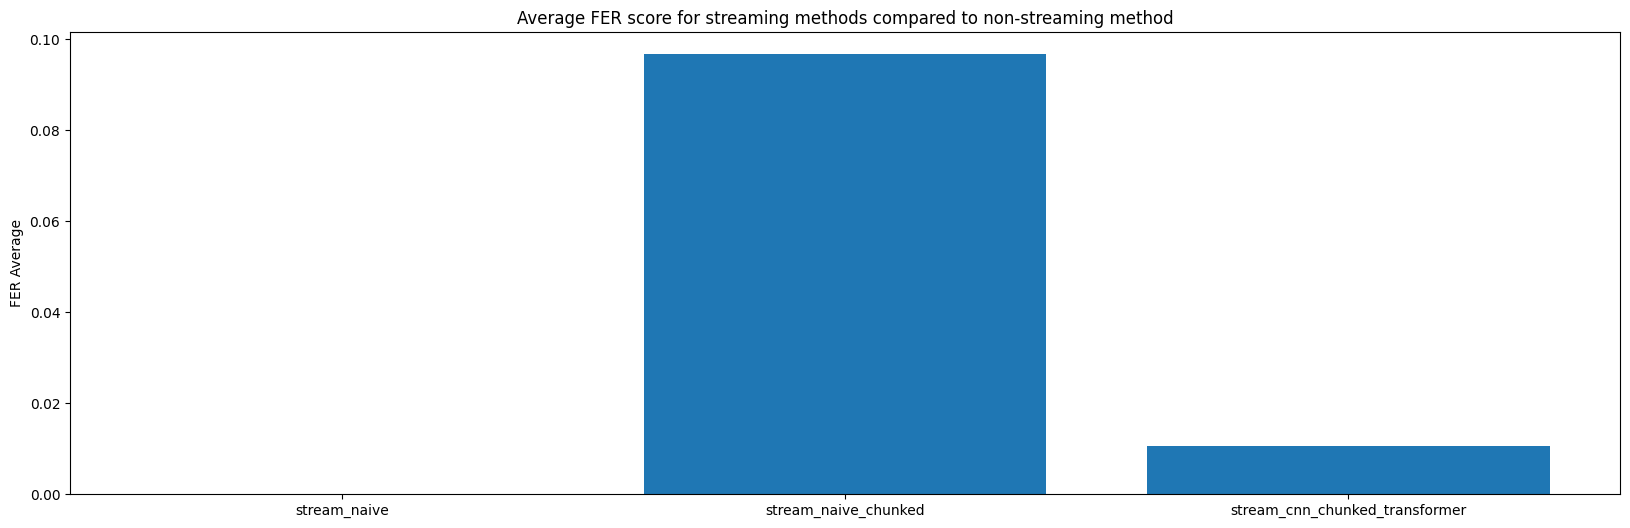

In [12]:
plt.figure(figsize=(20, 6))
plt.bar(
    ["stream_naive", "stream_naive_chunked", "stream_cnn_chunked_transformer"],
    [
        result_df["stream_naive_fer_scores"].mean(),
        result_df["stream_naive_chunked_fer_scores"].mean(),
        result_df["stream_cnn_chunked_transformer_fer_scores"].mean(),
    ]
)
plt.ylabel("FER Average")
plt.title("Average FER score for streaming methods compared to non-streaming method")


Text(0.5, 1.0, 'Speed Comparison')

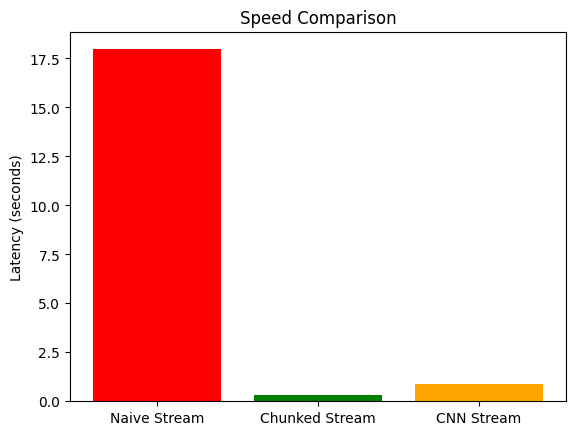

In [16]:
methods = ['stream_naive_average_final_guess_latency', 'stream_naive_chunked_average_final_guess_latency', 'stream_cnn_chunked_transformer_average_final_guess_latency']
labels = ['Naive Stream', 'Chunked Stream', 'CNN Stream']
latencies = [result_df[col].mean() for col in methods if col in result_df.columns]

plt.bar(labels[:len(latencies)], latencies, color=['red', 'green', 'orange'])
plt.ylabel('Latency (seconds)')
plt.title('Speed Comparison avg (final guess latency)')